# Min Norm Solution for Bleed Removal

In [1]:
import numpy as np
import numpy.linalg as linalg

In [2]:
import os
import librosa as lb
import soundfile as sf

#### Loading Bleed Sources

In [ ]:
Music Delta - Hendrix
Bill Chudziak - Children Of No-one

In [103]:
bleed_path = '/home/rajesh/Desktop/Datasets/musdb18hq_bleeded/train/Hollow Ground - Left Blind/'
bvocals, fs = lb.load(bleed_path+'vocals.wav')
bbass, fs = lb.load(bleed_path+'bass.wav')
bdrums, fs = lb.load(bleed_path+'drums.wav')
bother, fs = lb.load(bleed_path+'other.wav')

#### Loading True Sources

In [104]:
clean_path = '/home/rajesh/Desktop/Datasets/musdb18hq/train/Hollow Ground - Left Blind/'
vocals, fs = lb.load(clean_path+'vocals.wav')
bass, fs = lb.load(clean_path+'bass.wav')
drums, fs = lb.load(clean_path+'drums.wav')
other, fs = lb.load(clean_path+'other.wav')

In [105]:
if len(bbass) > len(bass):
    n = len(bass)
else:
    n = len(bbass)

In [106]:
R = np.array([bvocals[:n], bbass[:n], bdrums[:n], bother[:n]]) #two min
R.shape

(4, 3512345)

In [107]:
S = np.array([vocals[:n], bass[:n], drums[:n], other[:n]])
S.shape

(4, 3512345)

In [108]:
from matplotlib import pyplot as plt

In [109]:
def norm(A):
    forb = linalg.norm(A, ord='fro')
    l1 = linalg.norm(A, ord=1)
    l2 = linalg.norm(A, ord=2)
    return l1, l2, forb

# 27 Feb: Siddhartha sir's Block

In [110]:
def blockleastnormsoln(r, s):
    r = r.flatten()
    s = s.flatten()
    b = r-s
    
    val = int(r.shape[0]/4)
    s0 = s[0:val]
    s1 = s[val:2*val]
    s2 = s[2*val:3*val]
    s3 = s[3*val:4*val]
    
    z = np.zeros(val)

    c1 = np.hstack((s1, z, z, z))
    c2 = np.hstack((s2, z, z, z))
    c3 = np.hstack((s3, z, z, z))

    c4 = np.hstack((z, s0, z, z))
    c5 = np.hstack((z, s2, z, z))
    c6 = np.hstack((z, s3, z, z))

    c7 = np.hstack((z, z, s0, z))
    c8 = np.hstack((z, z, s1, z))
    c9 = np.hstack((z, z, s3, z))

    c10 = np.hstack((z, z, z, s0))
    c11 = np.hstack((z, z, z, s1))
    c12 = np.hstack((z, z, z, s2))
    
    A = np.stack((c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12), axis=1)
    
    soln, residual, rank, singular = linalg.lstsq(A, b, rcond=-1)
    
    return np.array([[1, soln[0], soln[1], soln[2]],
                     [soln[3], 1, soln[4], soln[5]],
                     [soln[6], soln[7], 1, soln[8]],
                     [soln[9], soln[10], soln[11], 1]])

In [111]:
time = 0.5 #seconds
block = int(time * fs)

In [112]:
block_lamda = []

for i in range(0, R.shape[1], block):
    r = R[: ,i:i+block]
    s = S[: ,i:i+block]
    block_lamda.append(blockleastnormsoln(r, s))

In [113]:
len(block_lamda)

319

In [114]:
block_lamda[0], block_lamda[1]

(array([[1.        , 0.89050194, 0.10796055, 0.28044728],
        [1.13282841, 1.        , 0.10768665, 0.27525079],
        [0.81417443, 0.67096968, 1.        , 0.24180894],
        [0.96968559, 0.76265933, 0.10705152, 1.        ]]),
 array([[1.        , 0.91247349, 0.12226828, 0.26717167],
        [1.15080343, 1.        , 0.12058396, 0.26134929],
        [0.8340166 , 0.71409627, 1.        , 0.23126154],
        [0.96595954, 0.78612434, 0.11704663, 1.        ]]))

In [115]:
l1, l2, forb = [], [], []
for i in range(len(block_lamda)):
    l_1, l_2, forbn = norm(block_lamda[i])
    l1.append(l_1)
    l2.append(l_2)
    forb.append(forbn)

In [116]:
x = np.arange(len(block_lamda))/2

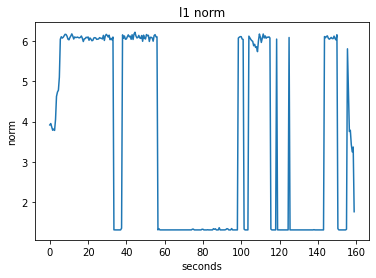

In [117]:
plt.plot(x, l1)
plt.title('l1 norm')
plt.xlabel('seconds')
plt.ylabel('norm')
plt.savefig('/home/rajesh/Desktop/l1.png', dpi = 1000)
plt.show()

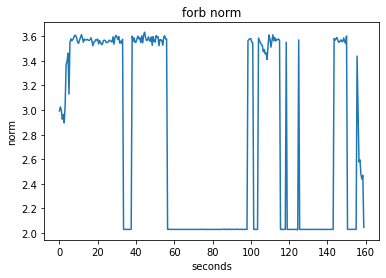

In [118]:
plt.plot(x, forb)
plt.title('forb norm')
plt.xlabel('seconds')
plt.ylabel('norm')
plt.savefig('/home/rajesh/Desktop/forb.png', dpi = 1000)
plt.show()

#### Difference Histograms

In [189]:
import itertools

In [216]:
block_lamda_comb = list(itertools.combinations(block_lamda, 2))

In [217]:
diff = []
for everyblock in block_lamda_comb:
    diff.append(everyblock[0]-everyblock[1])

In [218]:
l1, l2, forb = [], [], []
for i in range(len(diff)):
    l_1, l_2, forbn = norm(diff[i])
    l1.append(l_1)
    l2.append(l_2)
    forb.append(forbn)